In [8]:
# IMPORT STATEMENTS
import sys
import StepMiner as smn
import HegemonUtil as hu
import re
import numpy as np
import scipy
import io
from scipy import io
import math
import itertools
from itertools import combinations 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import statsmodels.stats.proportion
import seaborn as sns
import scanpy as sc
import GEOparse

### Analysis of GSE138002 (Lu 2020 scRNA-seq retina, n = 118,555)

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE138002
This notebook demonstrates some basic uses of the scanpy (Single-Cell Analysis in Python) package to analyze large scRNA-seq datasets such as GSE138002 with more than 100,000 cells.
<br>Plots from this analysis were used to validate high-confidence retinal cell type-specific genes discovered using Boolean analysis in the manuscript below:</br>

Rohan Subramanian, Debashis Sahoo. "Boolean Implication Analysis Improves Prediction Accuracy of In Silico Gene Reporting of Retinal Cell Types." bioRxiv 2020.09.28.317313;
doi: https://doi.org/10.1101/2020.09.28.317313

To get the data from GEO, run this command in your terminal.

wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE138nnn/GSE138002/suppl/GSE138002_Final_matrix.mtx.gz

In [8]:
path_dir='./'

#Generates the idx file from the expr file.
def make_idx():
    print('Starting make_idx')
    expr = path_dir+'lu-2020-2-expr.txt'

    ptr = []
    ids = []
    name = []
    desc = []
    pos = 0

    with open(expr, 'rb') as f:
        for line in f:
            if pos == 0:
                pos += len(line)
            else:
                ptr.append(pos)
                pos += len(line)
                split = line.decode("utf-8").split('\t')
                ids.append(split[0])
                name.append(split[1].split(':')[0])
                desc.append(':'.join(split[1].split(':')[1:]))
        f.close()

    with open(path_dir+'lu-2020-2-idx.txt', 'w') as f:
        f.write('ProbeID\tPtr\tName\tDescription\n')
        for i in range(len(ids)):
            f.write('{}\t{}\t{}\t{}\n'.format(ids[i], ptr[i], name[i], desc[i]))
        f.close()
    print("Done with make_idx")

We want to generate violin plots of gene expression by each cell type using the datsaset GSE138002.

In [ ]:
pathdir="/Users/rohan/public_html/Hegemon/Data2/Data/GSE138002/"
print("reading barcodes")
barcodes = pd.DataFrame(pd.read_csv(pathdir+'GSE138002_Final_barcodes.csv', sep = ';', header=0))
print("finished")
print("reading genes")
genes = pd.DataFrame(pd.read_csv(pathdir+'GSE138002_genes.csv', sep = ';',header=0))
genes.columns = ["ProbeID1","ProbeID","Name"]
genes = genes[["ProbeID","Name"]]
print("finished")
print("reading counts")
adata = (scipy.io.mmread(pathdir+'GSE138002_Final_matrix.mtx'))
adata = adata.todense()
adata = pd.DataFrame(adata)
print("finished")
print("normalizing")

# AnnData is a special format to store data used by the scanpy package.
adata = sc.AnnData(adata.T) 
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata

In [14]:
# AnnData objects have two main attributes: 
#     1. obs (observations which are characteristics for each sample/cell) 
#     2. var ("variables" such as gene names and IDs)
adata.obs['arr'] = np.array(barcodes['barcode'])
adata.var['gene_ids']=np.array(genes["ProbeID"])
adata.var['names']=np.array(genes["Name"])

In [17]:
adata.obs["arr"]

0             24_Day.AACTCCCGTTTAGGAA-1
1             24_Day.AGATCTGTCTTGCATT-1
2             24_Day.AGCAGCCTCCGCTGTT-1
3             24_Day.AGGGAGTTCGTAGATC-1
4             24_Day.ATTATCCTCGCCCTTA-1
                      ...              
118550    Hpnd8_rep2.TTTGGTTTCTCATTCA-1
118551    Hpnd8_rep2.TTTGTCAAGATCCGAG-1
118552    Hpnd8_rep2.TTTGTCACAGTTTACG-1
118553    Hpnd8_rep2.TTTGTCACATGTCCTC-1
118554    Hpnd8_rep2.TTTGTCAGTCTCCATC-1
Name: arr, Length: 118555, dtype: object

In [41]:
# We can populate the obs field of adata (an Anndata object) with more than just cell barcodes.
# The code below reads clinical characteristics for each cell from the survival file and adds it to adata.obs.

db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT59"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
print("Loaded hegemon object")

df = pd.read_csv(h.getSurv(), sep="\t")
print("Read surv file")
df.index = df.iloc[:,0]
for k in df.columns:
    k1 = re.sub("^c ", "", k)
    k1 = re.sub("^n ", "", k1)
    val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
    adata.obs[k1] = val
    print("read column")

Loaded hegemon object


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read surv file
read column
read column
read column
read column
read column
read column
read column
read column
read column
read column
read column
read column
read column


In [42]:
# Now, adata contains many clinical characteristics (AnnData as "annotated data")
adata

AnnData object with n_obs × n_vars = 118555 × 33694
    obs: 'arr', 'ArrayID', 'time', 'status', 'source', 'organism', 'donor', 'location', 'cluster label', 'cell type', 'barcode', 'title', 'cell source', 'developmental stage', 'molecule', 'source_name', 'tissue', 'age', 'sample_region'
    var: 'gene_ids', 'names'
    uns: 'log1p', 'cell type_colors'

In [47]:
# var_names needs to be the gene names, and the obs_names should ideally be the cell barcodes.
adata.var_names = adata.var["names"]
adata.obs_names = adata.obs["arr"]

In [59]:
# To generate plots of gene expression by cell type, we need to add this to adata too.
celltype = list(adata.obs["cell type"])
for i in range(len(celltype)):
    if celltype[i] == "Amacrine Cells":
        celltype[i] = "AC"
print(np.unique(celltype))
adata.obs["celltype"] = celltype
adata

['AC' 'AC/HC_Precurs' 'BC/Photo_Precurs' 'Bipolar Cells' 'Cones'
 'Horizontal Cells' 'Muller Glia' 'Neurogenic Cells' 'RPCs'
 'Retinal Ganglion Cells' 'Rods']


AnnData object with n_obs × n_vars = 118555 × 33694
    obs: 'arr', 'ArrayID', 'time', 'status', 'source', 'organism', 'donor', 'location', 'cluster label', 'cell type', 'barcode', 'title', 'cell source', 'developmental stage', 'molecule', 'source_name', 'tissue', 'age', 'sample_region', 'celltype'
    var: 'gene_ids', 'names'
    uns: 'log1p', 'cell type_colors'

In [89]:
# We also want to be able to separate each cell type in a particular type of retina, e.g. embryonic or neonatal. 
source = list(adata.obs["source_name"])
#Retinal Cells
celltype_RC = list(adata.obs["celltype"])
for i in range(len(celltype_RC)):
    if source[i] != "Retinal Cells":
        celltype_RC[i] = np.nan
adata.obs["celltype_RC"] = celltype_RC
#Embryonic
celltype_EC = list(adata.obs["celltype"])
for i in range(len(celltype_EC)):
    if source[i] != "human embryonic retina":
        celltype_EC[i] = np.nan
adata.obs["celltype_EC"] = celltype_EC
#Neonatal
celltype_NN = list(adata.obs["celltype"])
for i in range(len(celltype_NN)):
    if source[i] != "human neonatal retina":
        celltype_NN[i] = np.nan
print(np.unique(celltype_NN))
adata.obs["celltype_NN"] = celltype_NN

['AC' 'Bipolar Cells' 'Cones' 'Horizontal Cells' 'Muller Glia' 'RPCs'
 'Rods' 'nan']


Now, the data is ready and we can use sc.pl.violin to make violin plots for each cell type! 
The rest of the notebook generates a large number of plots, some of which were used in the manuscript.

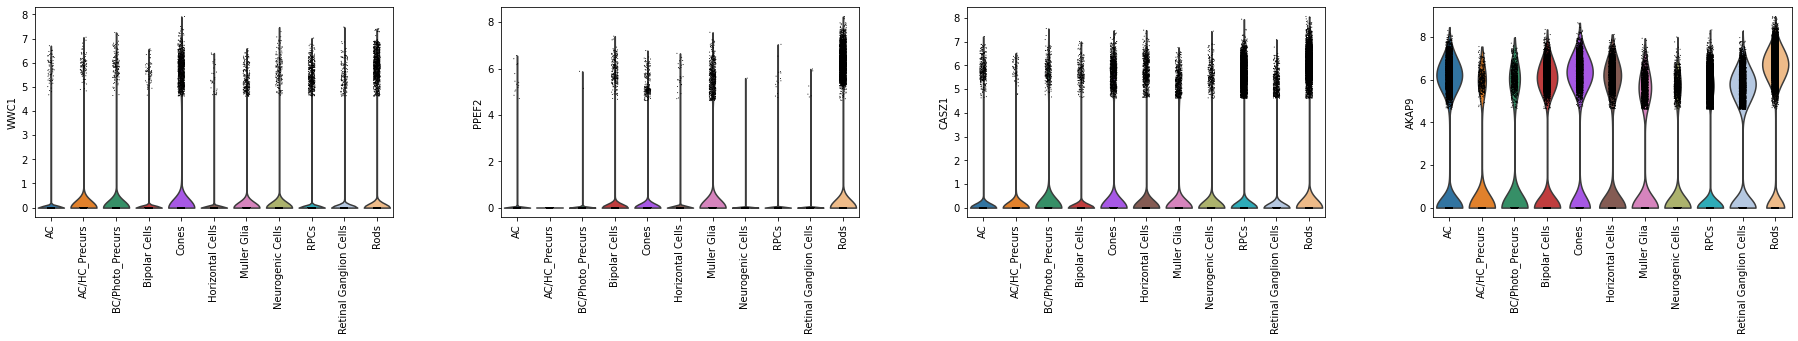

In [62]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="celltype", rotation=90)

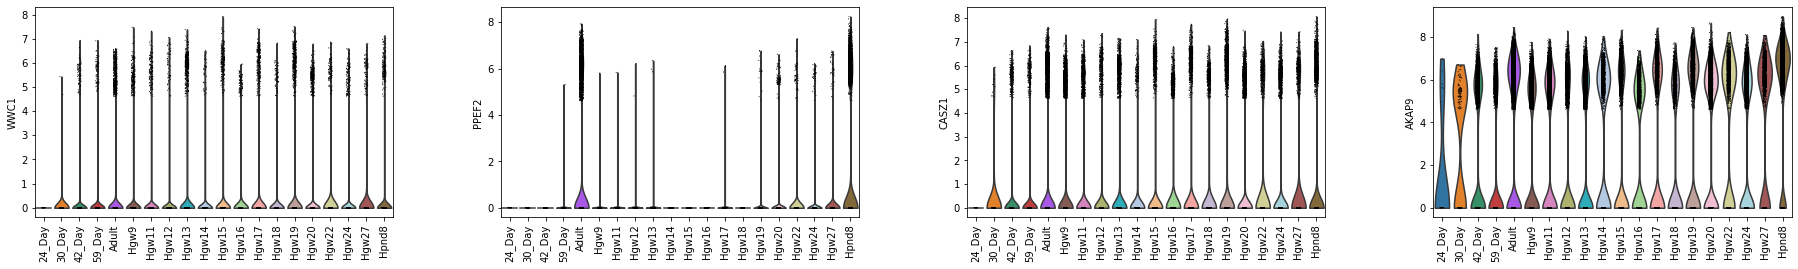

In [63]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="age", rotation=90)

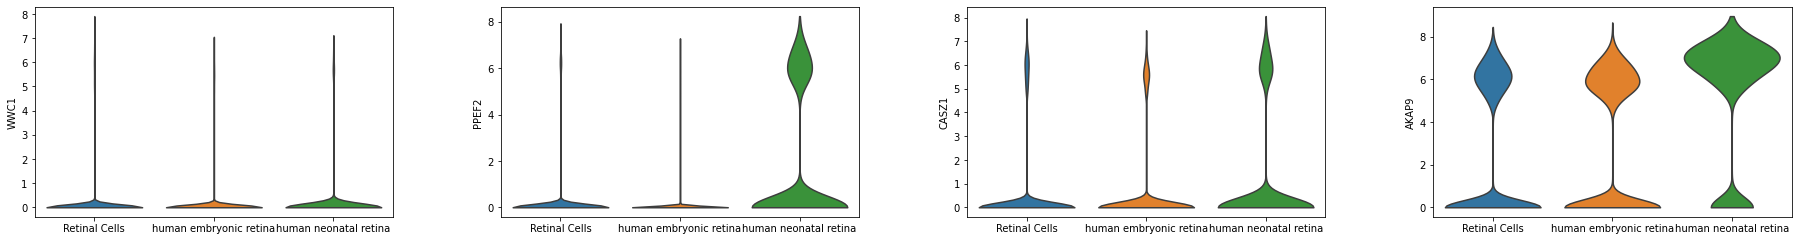

In [73]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="source_name", rotation=0, stripplot=False)

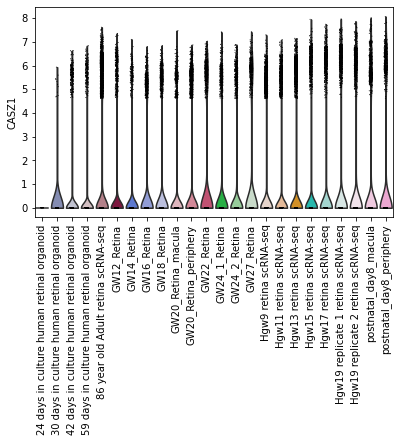

In [68]:
sc.pl.violin(adata, "CASZ1", groupby="title", rotation=90)

Retinal Cells


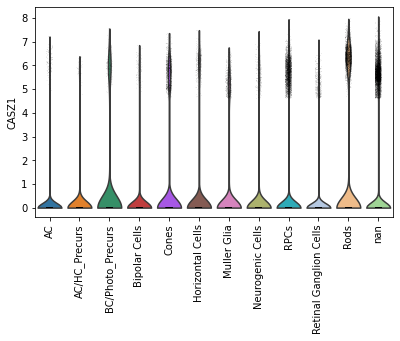

Human Embryonic Retina


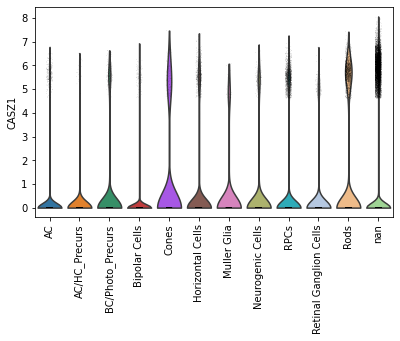

Human Neonatal Retina


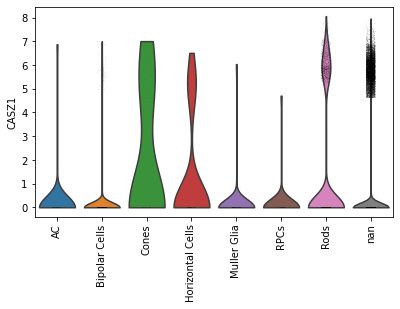

In [102]:
#CASZ1, Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90, size=0.3, save="CASZ1_RC_plots.pdf")
print("Human Embryonic Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90, size=0.3, save="CASZ1_EC_plots.pdf")
print("Human Neonatal Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90, size=0.3, save="CASZ1_NN_plots.pdf")
#sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90, stripplot=False)

Retinal Cells


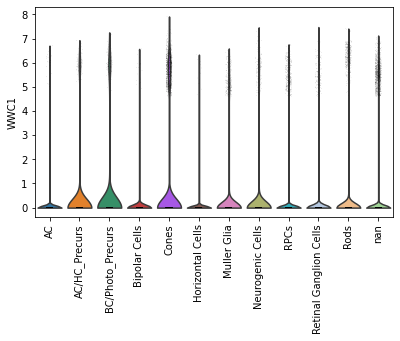

Human Embryonic Retina


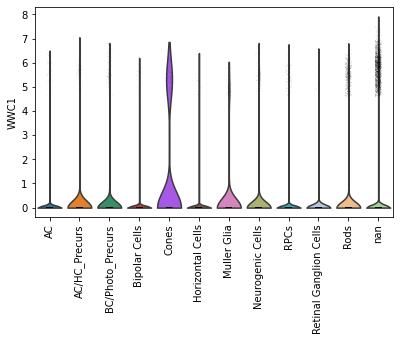

Human Neonatal Retina


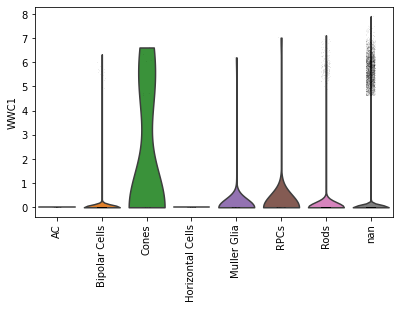

In [103]:
#WWC1, Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "WWC1", groupby="celltype_RC", rotation=90, size=0.3, save="WWC1_RC_plots.pdf")
print("Human Embryonic Retina")
sc.pl.violin(adata, "WWC1", groupby="celltype_EC", rotation=90, size=0.3, save="WWC1_EC_plots.pdf")
print("Human Neonatal Retina")
sc.pl.violin(adata, "WWC1", groupby="celltype_NN", rotation=90, size=0.3, save="WWC1_NN_plots.pdf")
#sc.pl.violin(adata, "WWC1", groupby="celltype_NN", rotation=90, stripplot=False)

Retinal Cells


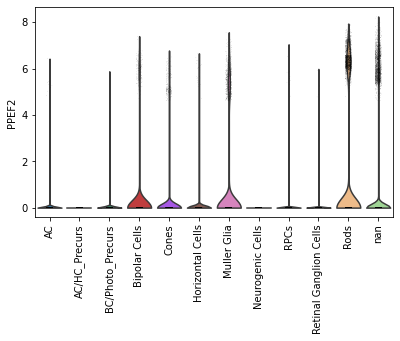

Human Embryonic Retina


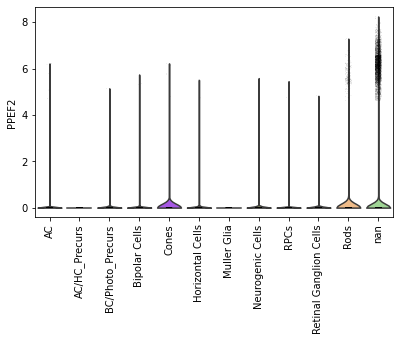

Human Neonatal Retina


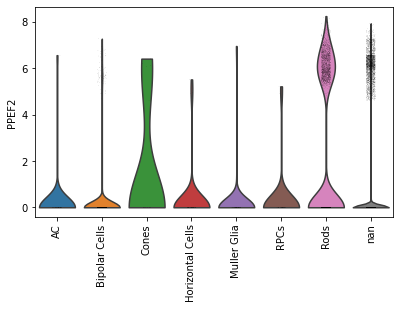

In [104]:
#PPEF2, Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "PPEF2", groupby="celltype_RC", rotation=90, size=0.3, save="PPEF2_RC_plots.pdf")
print("Human Embryonic Retina")
sc.pl.violin(adata, "PPEF2", groupby="celltype_EC", rotation=90, size=0.3, save="PPEF2_EC_plots.pdf")
print("Human Neonatal Retina")
sc.pl.violin(adata, "PPEF2", groupby="celltype_NN", rotation=90, size=0.3, save="PPEF2_NN_plots.pdf")
#sc.pl.violin(adata, "PPEF2", groupby="celltype_NN", rotation=90, stripplot=False)

Retinal Cells


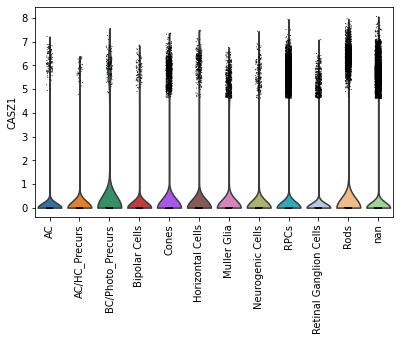

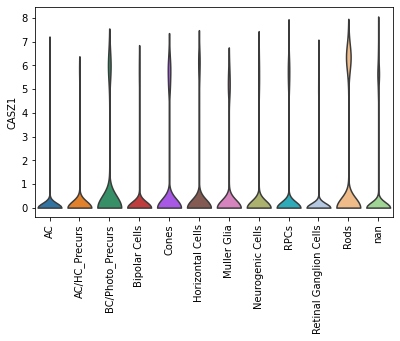

Human Embryonic Retina


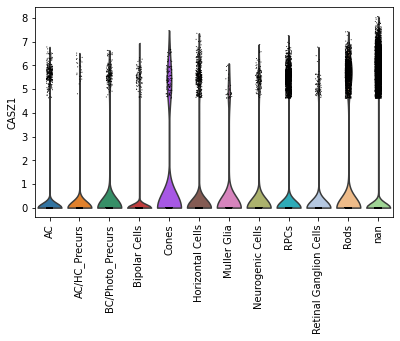

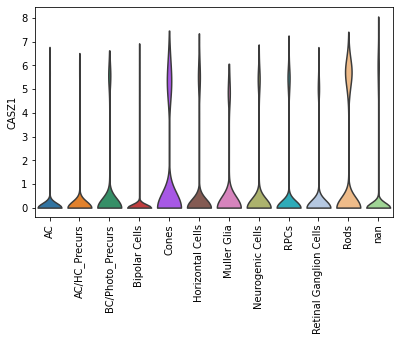

Human Neonatal Retina


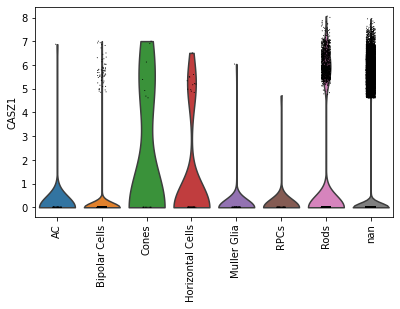

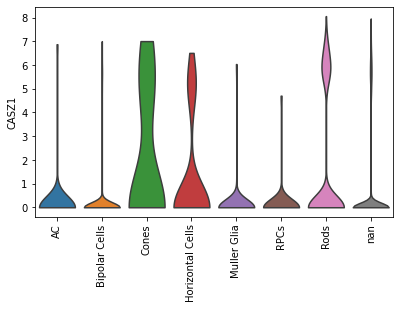

In [95]:
#Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90, stripplot=False)
print("Human Embryonic Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90, stripplot=False)
print("Human Neonatal Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90, stripplot=False)

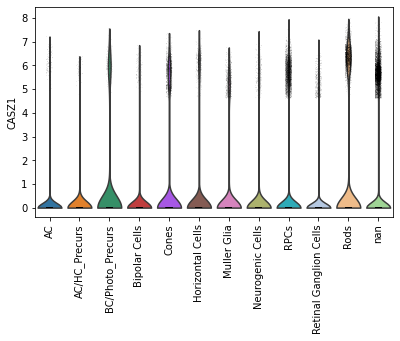

In [101]:
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", size=0.3, rotation=90,save="CASZ1_RC_plots.pdf")